# 1. Import the dataset

In [27]:
# import all the required libraries to import dataset

import requests
import json
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [28]:
# importing dataset from Alpha Vantage for Microsoft company using API key: 698TJNK0PAJT4YYP

CSV_URL ="https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=MSFT&apikey=698TJNK0PAJT4YYP&datatype=csv&outputsize=full"
with requests.Session() as s:
    download = s.get(CSV_URL)
    decoded_content = download.content.decode('utf-8')
    cr = csv.reader(decoded_content.splitlines(), delimiter=',')
    df = pd.DataFrame(cr)
new_header = df.iloc[0] 
df = df[1:] 
df.columns = new_header
df.head()

,timestamp,open,high,low,close,volume
1,2020-05-07,184.1700,186.5000,182.5800,183.6000,28243804
2,2020-05-06,182.0800,184.2000,181.6306,182.5400,32029937
3,2020-05-05,180.6200,183.6500,179.9000,180.7600,36839168
4,2020-05-04,174.4900,179.0000,173.8000,178.8400,30372862
5,2020-05-01,175.8000,178.6400,174.0100,174.5700,39370474


# 2. Data Preprocessing

In [29]:
# check the dimensions of the dataset (row, col)

df.shape

(5033, 6)

In [30]:
# check if there is any null value in the dataset

df.isnull().any().any()

False

In [31]:
# check if there is any duplicate value in the dataset 

df.duplicated().any()

False

### Since there is no missing or duplicate values, dataset is clean.

In [32]:
# add a new column which is the average of high and low price of the stock

cols = ['high','low']
df['mid_price'] = df[cols].astype(float).mean(axis=1)

In [33]:
df.head()

,timestamp,open,high,low,close,volume,mid_price
1,2020-05-07,184.1700,186.5000,182.5800,183.6000,28243804,184.5400
2,2020-05-06,182.0800,184.2000,181.6306,182.5400,32029937,182.9153
3,2020-05-05,180.6200,183.6500,179.9000,180.7600,36839168,181.7750
4,2020-05-04,174.4900,179.0000,173.8000,178.8400,30372862,176.4000
5,2020-05-01,175.8000,178.6400,174.0100,174.5700,39370474,176.3250


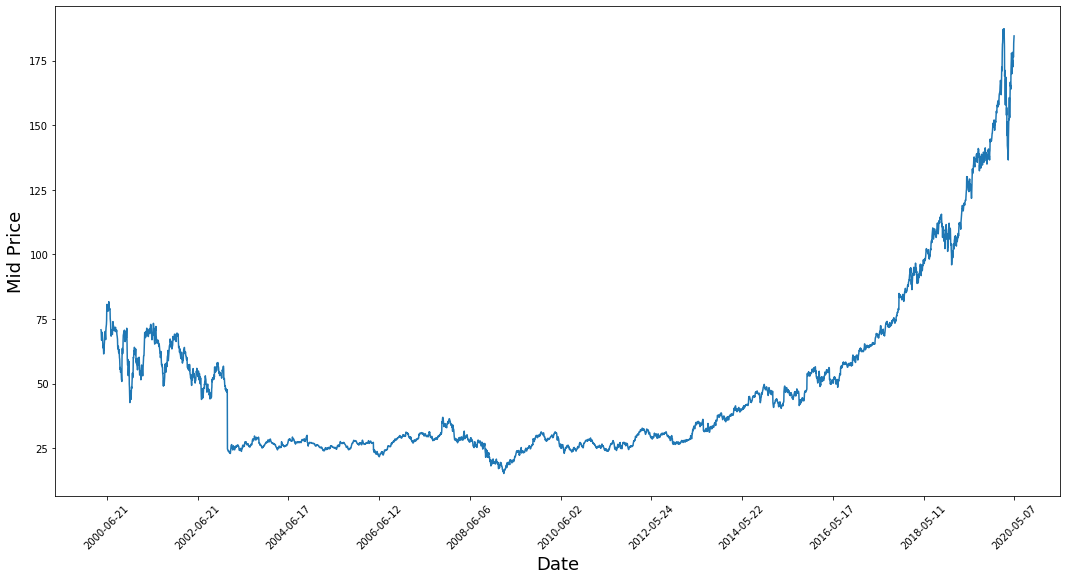

In [34]:
# Visualization of the mid_price column of the dataset

plt.figure(figsize = (18,9))
plt.plot(df['mid_price'])
plt.xticks(range(0,df.shape[0],500),df['timestamp'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.gca().invert_xaxis()
plt.show()

In [35]:
# Drop timestamp column, since it doesn't add any value for prediction purpose and it is not an int type.

df = df.drop(['timestamp'], axis=1)

In [36]:
# Convert the dataframe into numpy array.
# The dtype will be a lower-common-denominator dtype (implicit upcasting)
# Columns(e.g., str/object, int64, float32) will convert into object

df = df.to_numpy()

In [37]:
# Divide complete dataset sequentially into 80% training and 20% testing dataset.
# I have total 5033 rows

training_data = df[np.arange(0, int(np.floor(0.8*5033))), :]
testing_data = df[np.arange(int(np.floor(0.8*5033)), 5033), :]

In [38]:
# Data Scaling
# Since I am going to use neural network, it is beneficial to scale the input and output data
# I will use rectified linear unit (ReLU) activations which are unbounded on the axis of possible activation values.
# For Scaling I will use sklearn’s MinMaxScaler.

scale_normal = MinMaxScaler(feature_range=(-1, 1))
training_data = scale_normal.fit_transform(training_data)
testing_data = scale_normal.transform(testing_data)

In [39]:
# Build X and  Y axis, where
# X (input) indicates the price of the stock at time 't'
# Y (output) indicates the price of the stock at time 't+1'

X_train = training_data[:, 1:]
Y_train = training_data[:, 0]
X_test = testing_data[:, 1:]
Y_test = testing_data[:, 0]

# Learning of Neural Network model using Tensorflow

In [40]:
!pip install tensorflow

In [41]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [42]:
param = X_train.shape[1]
print(param)

5


In [43]:
# Session starts

neural_network_session = tf.InteractiveSession()

In [44]:
# X (input) is a 2D matrix and Y (output) is a 1D vector
# At this point I am not sure about the number of observation that neural network will take. Hence, given 'None'.

X = tf.placeholder(dtype=tf.float32, shape=[None, 5])
Y = tf.placeholder(dtype=tf.float32, shape=[None])

In [45]:
# Initialize the variables before training of the model starts
# I am using tf.variance_scaling_initializer() & tf.zeros_initializer() to initialize the weight and bias respectively

weight = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=1)
bias = tf.zeros_initializer()

In [46]:
# In feedforward network, I am considering 1 input, 4 hidden and 1 output layer
# input_layer: 5 neurons
# first_layer: 16 neurons
# second_layer: 8 neurons (half of the 1st layer)
# third_layer: 4 neurons (half of the 2nd layer)
# fourth_layer: 2 neurons (half of the 3rd layer)
# output_layer: 1 neuron

# first_layer
first_layer_weight = tf.Variable(weight([5, 16]))
first_layer_bias = tf.Variable(bias([16]))

# second_layer
second_layer_weight = tf.Variable(weight([16, 8]))
second_layer_bias = tf.Variable(bias([8]))

# third_layer
third_layer_weight = tf.Variable(weight([8, 4]))
third_layer_bias = tf.Variable(bias([4]))

# fourth_layer
fourth_layer_weight = tf.Variable(weight([4, 2]))
fourth_layer_bias = tf.Variable(bias([2]))

# output_layer
output_layer_weight = tf.Variable(weight([2, 1]))
output_layer_bias = tf.Variable(bias([1]))

In [47]:
# Matrix Multiplication between different layers of the neural network model

first_layer = tf.matmul(X, first_layer_weight)
second_layer = tf.matmul(first_layer, second_layer_weight)
third_layer = tf.matmul(second_layer, third_layer_weight)
fourth_layer = tf.matmul(third_layer, fourth_layer_weight)
output_layer = tf.matmul(fourth_layer, output_layer_weight)

In [48]:
# Hidden layers are transformed by activation functions and it also introduce non-linearity to the model.
# I will use rectified linear unit (ReLU) activations function.

first_hidden_layer = tf.nn.relu(tf.add(first_layer, first_layer_bias))
second_hidden_layer = tf.nn.relu(tf.add(second_layer, second_layer_bias))
third_hidden_layer = tf.nn.relu(tf.add(third_layer, third_layer_bias))
fourth_hidden_layer = tf.nn.relu(tf.add(fourth_layer, fourth_layer_bias))

In [49]:
# Take the transpose of output_target_layer

output_target_layer = tf.transpose(tf.add(output_layer, output_layer_bias))

In [50]:
# Cost function
# MSE(mean squared error) is the deviation between the predicted and the actual value. 

mean_squared_error = tf.reduce_mean(tf.squared_difference(output_target_layer, Y))

In [51]:
# Optimizer is used to choose weight and bias variables during training in order to minimize the cost function
# AdamOptimizer() is the combination of two other popular optimizers AdaGrad and RMSProp.

optimizer = tf.train.AdamOptimizer().minimize(mean_squared_error)

In [52]:
# Training of the model

neural_network_session.run(tf.global_variables_initializer())

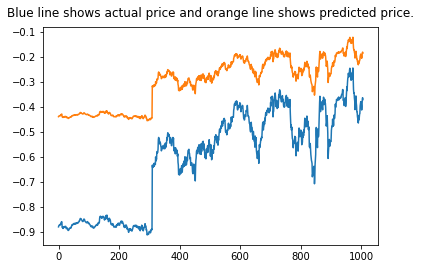

In [54]:
# Setup interactive plot

plt.ion()
fig = plt.figure()
a = fig.add_subplot(111)
line1 = a.plot(Y_test)
line2 = a.plot(Y_test*0.5)
plt.title("Blue line shows actual price and orange line shows predicted price.", y=1.02, fontsize=12);
#plt.gca().invert_xaxis()
plt.show()

In [55]:
# Fit neural network
# considering epochs=10 & batch_size = 50

mse_train = []
mse_test = []
for epochs in range(10):
    # Shuffle training data
    shuffle = np.random.permutation(np.arange(len(Y_train)))
    X_train = X_train[shuffle]
    Y_train = Y_train[shuffle]
    # Minibatch training
    for i in range(0, len(Y_train)):
        start = i * 50
        batchX = X_train[start:start + 50]
        batchY = Y_train[start:start + 50]
        # Run optimizer with batch
        neural_network_session.run(optimizer, feed_dict={X: batchX, Y: batchY})
        # Show progress
        if np.mod(i, 50) == 0:
            # MSE train and test
            mse_train.append(neural_network_session.run(mean_squared_error, feed_dict={X: X_train, Y: Y_train}))
            mse_test.append(neural_network_session.run(mean_squared_error, feed_dict={X: X_test, Y: Y_test}))
            # Prediction
            prediction = neural_network_session.run(output_target_layer, feed_dict={X: X_test})
print('MSE Train: ', mse_train[-1])
print('MSE Test: ', mse_test[-1])

MSE Train:  0.00010041545
MSE Test:  0.00012404985


In [56]:
# final MSE after Training the model

mse_final = neural_network_session.run(mean_squared_error, feed_dict={X: X_test, Y: Y_test})
print(mse_final)

0.00012404985
